# Distance Analysis: bonemarrow-codex-chop

> Analyze and visualize cell-to-nearest-endothelial-cell distance distributions for the `bonemarrow-codex-chop` dataset.

In [1]:
import numpy as np
import pandas as pd
import os
import json
import requests
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
import plotly.express as px

from cde_compute_edges_from_nodes import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# suppress warnings
import warnings
warnings.filterwarnings("ignore")   

In [2]:
basepath = "/u/yashjain/hra-cell-distance-analysis/data"
dataset_dir = "bonemarrow-codex-chop"
data_filedir = os.path.join("data-processed-nodes-with-harmonized-cell-types", dataset_dir)
output_edge_dir = os.path.join("data-processed-edges", dataset_dir)
figures_output_dir = "generated-figures"

In [3]:
# Function to load your data
def load_data(path, edges=False):
    if edges:
        column_names = ['cell_id', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2']
        data = pd.read_csv(path, header=None, names=column_names)
    else:
        data = pd.read_csv(path)
    return data

In [4]:
# Function to read all files ending with "-nodes.csv" in the `data_filedir` directory into a single DataFrame. 
# Another additional column `Dataset` is added to identify the dataset name which comes from the filename before the `-nodes.csv` suffix.

# Additionally, function reads all files ending with "-edges.csv" in the `output_edge_dir` directory into a single DataFrame. 
# Three additional columns are added "Dataset", "Anchor Cell Type", and "Anchor Cell Type Level" to identify the dataset name, anchor cell type, and anchor cell type level respectively which come from the filename before the `.csv` suffix.
# The three additional columns are created by splitting the filename on the `-` character, and extracting the relevant parts.
# On splitting, the first part is the dataset name, second part is the anchor cell type level, and third part is the anchor cell type, and last part is the `edges` suffix.
# When reading files, check if the file has the correct format (i.e., ends with `-edges.csv`).

# Additionally, the function merges the edges DataFrame with the nodes DataFrame to get the cell type information for the anchor cells.
# This is done by reading the corresponding nodes file from the `data_filedir` directory for each edges file, and merging it with the edges DataFrame on the `cell_id` column.
# The merged DataFrame contains the edges with additional columns for the cell type information.

# The function returns three DataFrames:
# 1. `merged_nodes`: DataFrame containing all nodes with an additional column `Dataset`.
# 2. `merged_edges`: DataFrame containing all edges with additional columns `Dataset`, `Anchor Cell Type`, and `Anchor Cell Type Level`.
# 3. `merged_nodes_for_all_edges`: DataFrame containing all edges with additional columns `Dataset`, `Anchor Cell Type`, `Anchor Cell Type Level`, and the cell type information for cells.
def read_all_edge_datasets(basepath, data_filedir, output_edge_dir):
    all_nodes_files = []
    all_edges_files = []
    all_nodes_edges_files = []
    for file in os.listdir(os.path.join(basepath, output_edge_dir)):
        if file.endswith("-edges.csv"):
            file_path = os.path.join(basepath, output_edge_dir, file)
            dataset_name, anchor_cell_type_level, anchor_cell_type = file.replace("-edges.csv", "").split('-')
            edges_df = load_data(file_path, edges=False)
            edges_df['Dataset'] = dataset_name
            edges_df['Anchor Cell Type'] = anchor_cell_type
            edges_df['Anchor Cell Type Level'] = anchor_cell_type_level
            edges_df.rename(columns={"distance": "Distance"}, inplace=True) # Rename column "distance" to "Distance".
            all_edges_files.append(edges_df)

            # Read the corresponding nodes file from data_filedir to get the cell type information
            nodes_file_path = os.path.join(basepath, data_filedir, f"{dataset_name}-nodes.csv")
            nodes_df = load_data(nodes_file_path)
            nodes_df['Dataset'] = dataset_name
            all_nodes_files.append(nodes_df)

            # Add a new 'cell_id' column to nodes_df
            nodes_df['cell_id'] = range(len(nodes_df))
            # Set 'cell_id' column as index for nodes_df
            nodes_df.set_index('cell_id', inplace=True)
            # Merge edges_df with nodes_df to get the cell type information for the anchor cells
            edges_nodes_df = pd.merge(edges_df, nodes_df[['Level Three Cell Type', 'Level Two Cell Type', 'Level One Cell Type']], how='left', left_on='cell_id', right_index=True)
            all_nodes_edges_files.append(edges_nodes_df)

    
    merged_edges = pd.concat(all_edges_files, ignore_index=True)
    merged_nodes = pd.concat(all_nodes_files, ignore_index=True)
    merged_nodes_for_all_edges = pd.concat(all_nodes_edges_files, ignore_index=True) 

    return merged_nodes, merged_edges, merged_nodes_for_all_edges

In [5]:
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created successfully.")
    else:
        print(f"Directory '{directory}' already exists.")

## Get initial statistics and identify endothelial cell categories for dataset.

In [6]:
df_all_nodes, df_all_edges, df_all_edges_with_cell_types = read_all_edge_datasets(basepath, data_filedir, output_edge_dir)

In [7]:
df_all_nodes.head(5)

,x,y,Original Cell Type,Level Three Cell Type,Level Three CL Label,Level Three CL ID,CL_Match/3,Level Two Cell Type,Level Two CL Label,Level Two CL ID,CL_Match/2,Level One Cell Type,Level One CL Label,Level One CL ID,CL_Match/1,Dataset
0,5776.546667,4000.546667,Erythroid,erythroid lineage cell,erythroid lineage cell,CL:0000764,skos:exactMatch,erythroid precursor,erythroid progenitor cell,CL:0000038,skos:exactMatch,hematopoeitic precursor cell,hematopoietic precursor cell,CL:0008001,skos:exactMatch,SB67_NBM48_NSM1_1720
1,6406.298077,4001.134615,B-Cells,b cell,B cell,CL:0000236,skos:exactMatch,b cell,B cell,CL:0000236,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,SB67_NBM48_NSM1_1720
2,6805.010526,4000.701754,Erythroid,erythroid lineage cell,erythroid lineage cell,CL:0000764,skos:exactMatch,erythroid precursor,erythroid progenitor cell,CL:0000038,skos:exactMatch,hematopoeitic precursor cell,hematopoietic precursor cell,CL:0008001,skos:exactMatch,SB67_NBM48_NSM1_1720
3,6032.794326,4002.039007,AEC,endothelial cell of artery,endothelial cell of artery,CL:1000413,skos:exactMatch,endothelial cell of artery,endothelial cell of artery,CL:1000413,skos:exactMatch,endothelial cell,endothelial cell,CL:0000115,skos:exactMatch,SB67_NBM48_NSM1_1720
4,6159.116364,4001.763636,Early Myeloid Progenitor,myeloid progenitor cell:common,common myeloid progenitor,CL:0000049,skos:exactMatch,progenitor cell,hematopoietic precursor cell,CL:0008001,skos:exactMatch,hematopoeitic precursor cell,hematopoietic precursor cell,CL:0008001,skos:exactMatch,SB67_NBM48_NSM1_1720


In [8]:
# Print the total number of unique cell types per dataset. Compute separately for each cell type column (Level One Cell Type, Level Two Cell Type, Level Three Cell Type, Original Cell Type).
print("Total number of unique cell types per cell type annnotation level:")
unique_cell_types = {
    'Original Cell Type': df_all_nodes['Original Cell Type'].nunique(),
    'Level Three Cell Type': df_all_nodes['Level Three Cell Type'].nunique(),
    'Level Two Cell Type': df_all_nodes['Level Two Cell Type'].nunique(),
    'Level One Cell Type': df_all_nodes['Level One Cell Type'].nunique()
}
for cell_type, count in unique_cell_types.items():
    print(f"{cell_type}: {count}")

Total number of unique cell types per cell type annnotation level:
Original Cell Type: 37
Level Three Cell Type: 33
Level Two Cell Type: 22
Level One Cell Type: 6


In [9]:
# Save the unique cell types containing "endothelial" in name per cell type column (Level One Cell Type, Level Two Cell Type, Level Three Cell Type, Original Cell Type) to a dictionary where the key is the level and the value is a list of unique cell types.
endothelial_cell_types = {
    'Original Cell Type': df_all_nodes[df_all_nodes['Original Cell Type'].str.contains("endothelial", case=False, na=False)]['Original Cell Type'].unique().tolist(),
    'Level Three Cell Type': df_all_nodes[df_all_nodes['Level Three Cell Type'].str.contains("endothelial", case=False, na=False)]['Level Three Cell Type'].unique().tolist(),
    'Level Two Cell Type': df_all_nodes[df_all_nodes['Level Two Cell Type'].str.contains("endothelial", case=False, na=False)]['Level Two Cell Type'].unique().tolist(),
    'Level One Cell Type': df_all_nodes[df_all_nodes['Level One Cell Type'].str.contains("endothelial", case=False, na=False)]['Level One Cell Type'].unique().tolist()
}

print("\nEndothelial cell types per cell type annotation level:")
for level, cell_types in endothelial_cell_types.items():
    print(f"\n{level}:")
    for cell in cell_types:
        print(f"  - {cell}")


Endothelial cell types per cell type annotation level:

Original Cell Type:

Level Three Cell Type:
  - endothelial cell of artery
  - endothelial cell of sinusoid

Level Two Cell Type:
  - endothelial cell of artery
  - endothelial cell of sinusoid

Level One Cell Type:
  - endothelial cell


In [10]:
type_field_list = ["Level Three Cell Type", "Level Two Cell Type", "Level One Cell Type"] # Skipping Original Cell Type as it is not a hierarchical level.

# Define the anchor cell type (type of endothelial cell) for each level in type_field_list based on available categories in the previous cell. The distance analysis at all three levels will be limited to the specified anchor cell type.
anchor_cell_type_dict = {
    'Level Three Cell Type': 'endothelial cell of sinusoid', # Picking sinusoid instead of artery because the cell count of sinusoid is higher than artery in the dataset.
    'Level Two Cell Type': 'endothelial cell of sinusoid',
    'Level One Cell Type': 'endothelial cell'
}

## Process datasets to add region information to Nodes files.

In [11]:
# Print unique values in Dataset column as a list.
print("\nUnique values in Dataset column:")
print(df_all_edges['Dataset'].unique().tolist())


Unique values in Dataset column:
['SB67_NBM48_NSM1_1720', 'SB67_NBM49_NSM2_1086', 'SB67_NBM47_NSM3_1996', 'SB67_NBM51_AML1_183', 'SB67_NBM46_AML1_382', 'SB67_NBM44_AML2_191', 'SB67_NBM52_AML3_1329', 'SB67_NBM54_AML3_1443', 'SB67_NBM27_H10', 'SB67_NBM28_H14', 'SB67_NBM36_H26', 'SB67_NBM41_H27', 'SB67_NBM31_H32', 'SB67_NBM38_H33', 'SB67_NBM37_H35', 'SB67_NBM33_H36', 'SB67_NBM32_H37', 'SB67_NBM34_H38', 'SB67_NBM40_H39', 'SB67_NBM39_H41']


In [12]:
# Create a dictionary to map bone marrow regions to correct region names (conditions).
# AML = Acute Myeloid Leukemia
# NSM = Negative lymphoma Staging bone Marrow biopsies
# NBM = Normal Bone Marrow
region_map = {
    'SB67_NBM48_NSM1_1720': 'NSM', 
    'SB67_NBM49_NSM2_1086': 'NSM', 
    'SB67_NBM47_NSM3_1996': 'NSM', 
    'SB67_NBM51_AML1_183': 'AML', 
    'SB67_NBM46_AML1_382': 'AML', 
    'SB67_NBM44_AML2_191': 'AML', 
    'SB67_NBM52_AML3_1329': 'AML', 
    'SB67_NBM54_AML3_1443': 'AML', 
    'SB67_NBM27_H10': 'NBM', 
    'SB67_NBM28_H14': 'NBM', 
    'SB67_NBM36_H26': 'NBM', 
    'SB67_NBM41_H27': 'NBM', 
    'SB67_NBM31_H32': 'NBM', 
    'SB67_NBM38_H33': 'NBM', 
    'SB67_NBM37_H35': 'NBM', 
    'SB67_NBM33_H36': 'NBM', 
    'SB67_NBM32_H37': 'NBM', 
    'SB67_NBM34_H38': 'NBM', 
    'SB67_NBM40_H39': 'NBM', 
    'SB67_NBM39_H41': 'NBM'
}

In [13]:
df_all_nodes.head()

,x,y,Original Cell Type,Level Three Cell Type,Level Three CL Label,Level Three CL ID,CL_Match/3,Level Two Cell Type,Level Two CL Label,Level Two CL ID,CL_Match/2,Level One Cell Type,Level One CL Label,Level One CL ID,CL_Match/1,Dataset
0,5776.546667,4000.546667,Erythroid,erythroid lineage cell,erythroid lineage cell,CL:0000764,skos:exactMatch,erythroid precursor,erythroid progenitor cell,CL:0000038,skos:exactMatch,hematopoeitic precursor cell,hematopoietic precursor cell,CL:0008001,skos:exactMatch,SB67_NBM48_NSM1_1720
1,6406.298077,4001.134615,B-Cells,b cell,B cell,CL:0000236,skos:exactMatch,b cell,B cell,CL:0000236,skos:exactMatch,immune cell,leukocyte,CL:0000738,skos:exactMatch,SB67_NBM48_NSM1_1720
2,6805.010526,4000.701754,Erythroid,erythroid lineage cell,erythroid lineage cell,CL:0000764,skos:exactMatch,erythroid precursor,erythroid progenitor cell,CL:0000038,skos:exactMatch,hematopoeitic precursor cell,hematopoietic precursor cell,CL:0008001,skos:exactMatch,SB67_NBM48_NSM1_1720
3,6032.794326,4002.039007,AEC,endothelial cell of artery,endothelial cell of artery,CL:1000413,skos:exactMatch,endothelial cell of artery,endothelial cell of artery,CL:1000413,skos:exactMatch,endothelial cell,endothelial cell,CL:0000115,skos:exactMatch,SB67_NBM48_NSM1_1720
4,6159.116364,4001.763636,Early Myeloid Progenitor,myeloid progenitor cell:common,common myeloid progenitor,CL:0000049,skos:exactMatch,progenitor cell,hematopoietic precursor cell,CL:0008001,skos:exactMatch,hematopoeitic precursor cell,hematopoietic precursor cell,CL:0008001,skos:exactMatch,SB67_NBM48_NSM1_1720


In [14]:
# Iterate through the df_all_data dataframe to create new column "Unique Region" based on the "Dataset" column.
# The "Unique Region" column is created by mapping the region names based on the full dataset name.
df_all_nodes['Unique Region'] = df_all_nodes['Dataset'].map(region_map)
# df_all_nodes['Unique Region'] = df_all_nodes['Dataset'].str.split('-').str[1].map(region_map)

# Check if the new columns are created correctly.
df_all_nodes[['Dataset', 'Unique Region']].head(5)

,Dataset,Unique Region
0,SB67_NBM48_NSM1_1720,NSM
1,SB67_NBM48_NSM1_1720,NSM
2,SB67_NBM48_NSM1_1720,NSM
3,SB67_NBM48_NSM1_1720,NSM
4,SB67_NBM48_NSM1_1720,NSM


In [15]:
# Print all unique regions in the data.
print("\nUnique Regions in the data:")
print(df_all_nodes['Unique Region'].unique())

# Print the total number of unique regions.
print(f"Total number of unique regions: {df_all_nodes['Unique Region'].nunique()}")

# Print number of unique datasets per unique region.
print("\nNumber of unique datasets per unique region:")
for region in df_all_nodes['Unique Region'].unique():
    num_datasets = df_all_nodes[df_all_nodes['Unique Region'] == region]['Dataset'].nunique()
    print(f"{region}: {num_datasets}")



Unique Regions in the data:
['NSM' 'AML' 'NBM']
Total number of unique regions: 3

Number of unique datasets per unique region:
NSM: 3
AML: 5
NBM: 12


## Process datasets to add region information to Edges files.

In [16]:
df_all_edges.head(5)

,cell_id,x1,y1,z1,x2,y2,z2,Distance,Dataset,Anchor Cell Type,Anchor Cell Type Level
0,1117,5746.650000,4541.361111,0,5895.403361,4573.613445,0,152.209644,SB67_NBM48_NSM1_1720,endothelial cell of artery,Level Three Cell Type
1,1145,5734.788679,4551.400000,0,5895.403361,4573.613445,0,162.143496,SB67_NBM48_NSM1_1720,endothelial cell of artery,Level Three Cell Type
2,1151,5756.300000,4553.104348,0,5895.403361,4573.613445,0,140.607141,SB67_NBM48_NSM1_1720,endothelial cell of artery,Level Three Cell Type
3,1185,5746.238095,4563.619048,0,5895.403361,4573.613445,0,149.499714,SB67_NBM48_NSM1_1720,endothelial cell of artery,Level Three Cell Type
4,1268,5624.227027,4594.664865,0,5541.917031,4700.170306,0,133.814549,SB67_NBM48_NSM1_1720,endothelial cell of artery,Level Three Cell Type


In [17]:
# Process the edge data to create new columns "Unique Region" based on the "Dataset" column, similar to how it was done for the node data.
df_all_edges['Unique Region'] = df_all_edges['Dataset'].map(region_map)

# Check if the new columns are created correctly.
df_all_edges[['Dataset', 'Unique Region']].head(5)

,Dataset,Unique Region
0,SB67_NBM48_NSM1_1720,NSM
1,SB67_NBM48_NSM1_1720,NSM
2,SB67_NBM48_NSM1_1720,NSM
3,SB67_NBM48_NSM1_1720,NSM
4,SB67_NBM48_NSM1_1720,NSM


In [18]:
# Print all unique regions in the data.
print("\nUnique Regions in the data:")
print(df_all_edges['Unique Region'].unique())

# Print the total number of unique regions.
print(f"Total number of unique regions: {df_all_edges['Unique Region'].nunique()}")

# Print number of unique datasets per unique region.
print("\nNumber of unique datasets per unique region:")
for region in df_all_edges['Unique Region'].unique():
    num_datasets = df_all_edges[df_all_edges['Unique Region'] == region]['Dataset'].nunique()
    print(f"{region}: {num_datasets}")



Unique Regions in the data:
['NSM' 'AML' 'NBM']
Total number of unique regions: 3

Number of unique datasets per unique region:
NSM: 3
AML: 5
NBM: 12


In [19]:
df_all_edges_with_cell_types['Unique Region'] = df_all_edges_with_cell_types['Dataset'].map(region_map)

# Check if the new columns are created correctly.
df_all_edges_with_cell_types[['Dataset', 'Unique Region']].head(5)

,Dataset,Unique Region
0,SB67_NBM48_NSM1_1720,NSM
1,SB67_NBM48_NSM1_1720,NSM
2,SB67_NBM48_NSM1_1720,NSM
3,SB67_NBM48_NSM1_1720,NSM
4,SB67_NBM48_NSM1_1720,NSM


In [20]:
df_all_nodes.head(1)

,x,y,Original Cell Type,Level Three Cell Type,Level Three CL Label,Level Three CL ID,CL_Match/3,Level Two Cell Type,Level Two CL Label,Level Two CL ID,CL_Match/2,Level One Cell Type,Level One CL Label,Level One CL ID,CL_Match/1,Dataset,Unique Region
0,5776.546667,4000.546667,Erythroid,erythroid lineage cell,erythroid lineage cell,CL:0000764,skos:exactMatch,erythroid precursor,erythroid progenitor cell,CL:0000038,skos:exactMatch,hematopoeitic precursor cell,hematopoietic precursor cell,CL:0008001,skos:exactMatch,SB67_NBM48_NSM1_1720,NSM


In [21]:
df_all_edges.head(1)

,cell_id,x1,y1,z1,x2,y2,z2,Distance,Dataset,Anchor Cell Type,Anchor Cell Type Level,Unique Region
0,1117,5746.65,4541.361111,0,5895.403361,4573.613445,0,152.209644,SB67_NBM48_NSM1_1720,endothelial cell of artery,Level Three Cell Type,NSM


In [22]:
df_all_edges_with_cell_types.head(1)

,cell_id,x1,y1,z1,x2,y2,z2,Distance,Dataset,Anchor Cell Type,Anchor Cell Type Level,Level Three Cell Type,Level Two Cell Type,Level One Cell Type,Unique Region
0,1117,5746.65,4541.361111,0,5895.403361,4573.613445,0,152.209644,SB67_NBM48_NSM1_1720,endothelial cell of artery,Level Three Cell Type,erythroid lineage cell,erythroid precursor,hematopoeitic precursor cell,NSM


## Node Analysis

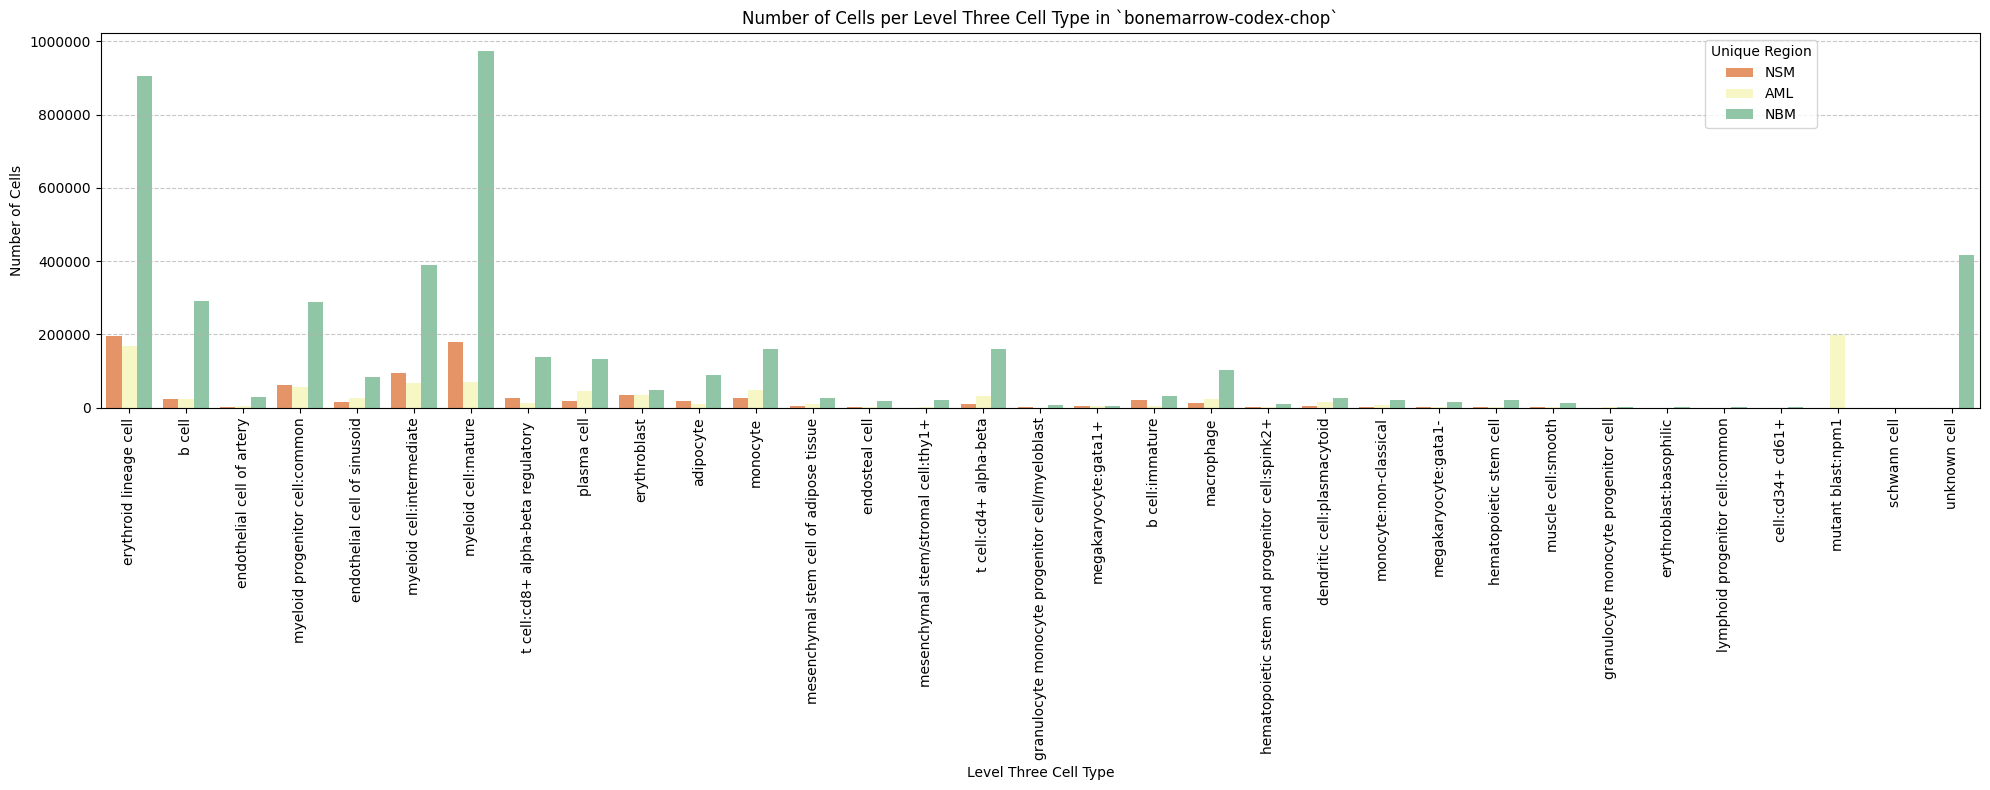

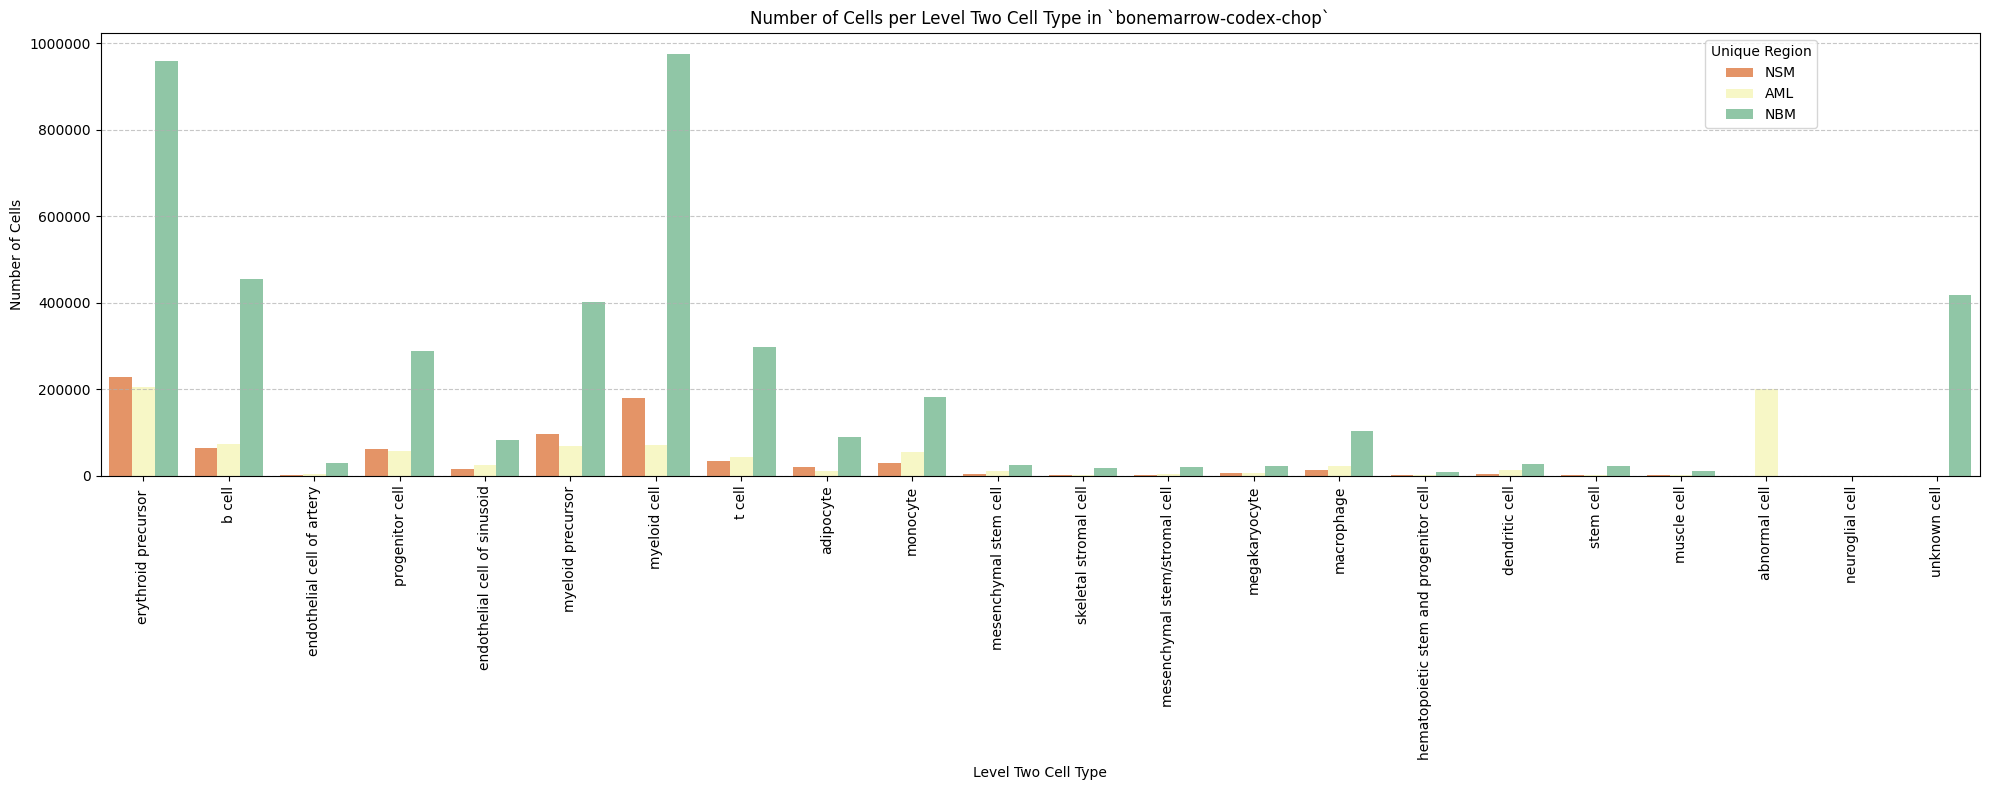

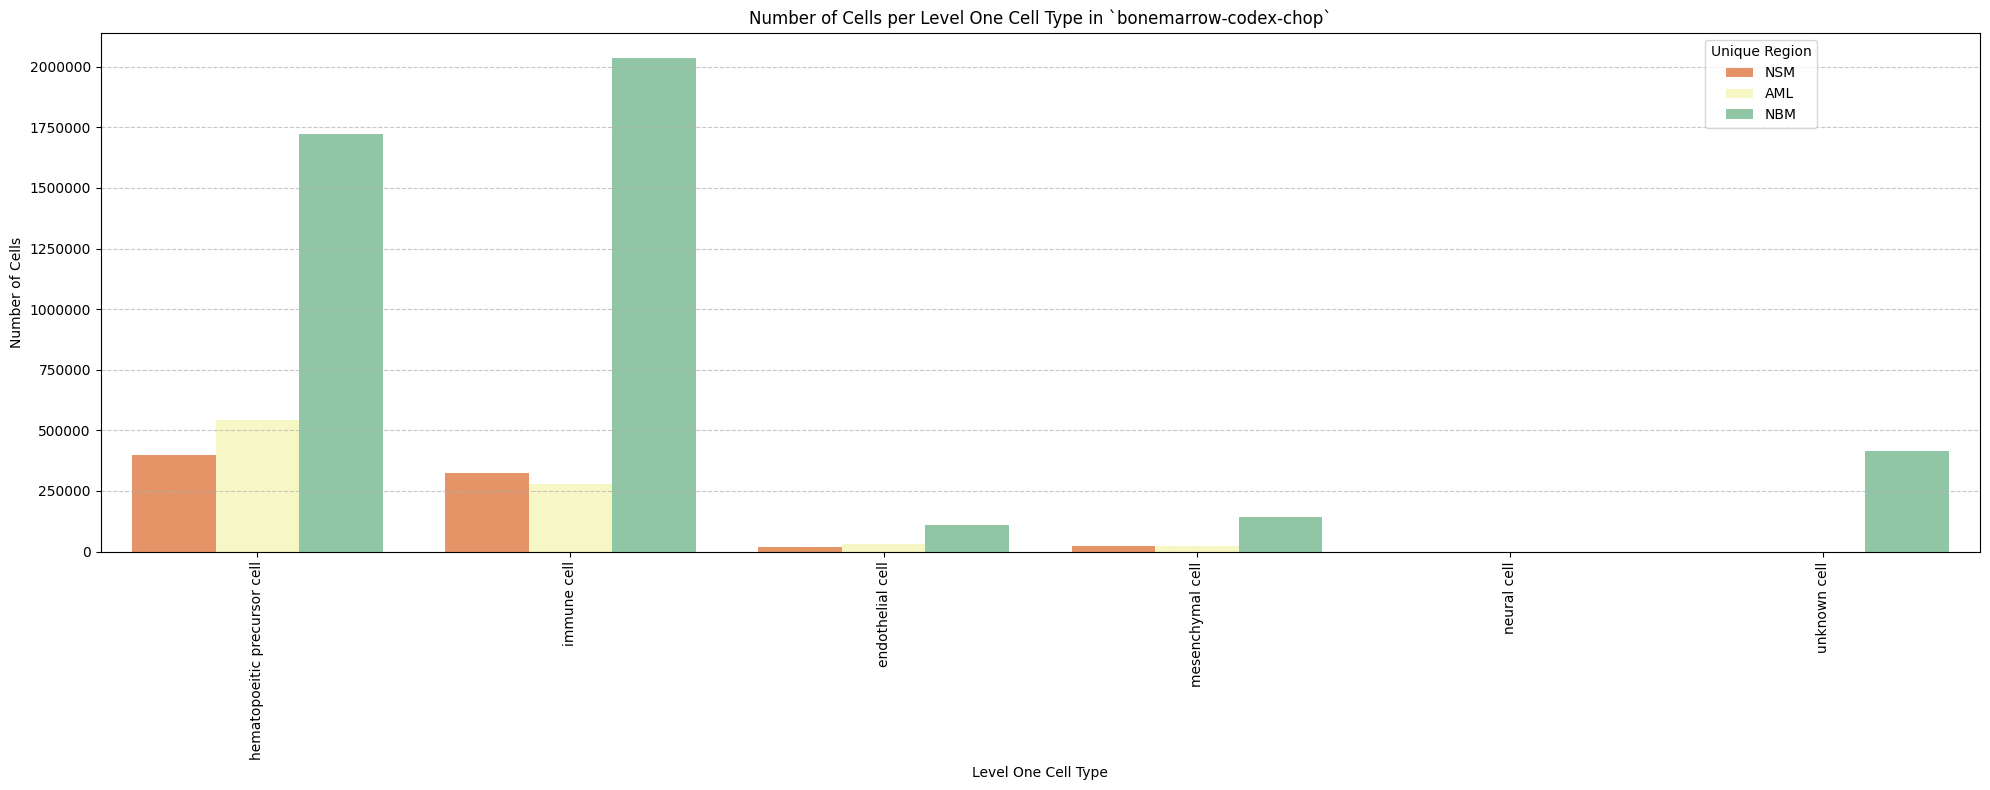

In [23]:
# Plot number of cells per cell type in the same plot. Color by cell type and unique region. Output figure saved in existing `figures_output_dir`.
def plot_cells_per_celltype(df, type_field, output_dir):
    plt.figure(figsize=(20, 8))
    sns.countplot(data=df, x=type_field, palette='Spectral', hue='Unique Region')
    plt.title(f'Number of Cells per {type_field} in `{dataset_dir}`')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_cells_per_celltype_{type_field}.png'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_cells_per_celltype_{type_field}.svg'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.legend(title='Unique Region', bbox_to_anchor=(0.85, 1), loc='upper left')
    plt.xlabel(type_field)

    # For numbers on y-axis, do not use scientific notation.
    plt.ticklabel_format(style='plain', axis='y')
    # Set y-axis label
    plt.ylabel('Number of Cells')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    # Show the plot
    plt.show()
    plt.close()
for type_field in type_field_list:
    plot_cells_per_celltype(df_all_nodes, type_field, os.path.join(basepath, figures_output_dir))

## Distance Analysis

In [24]:
# Get mean, median, minimum, maximum distance per unique region per anchor cell type.
df_distance_stats = df_all_edges_with_cell_types.groupby(['Unique Region', 'Anchor Cell Type', 'Anchor Cell Type Level']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
# Print the first few rows of the distance statistics DataFrame.
df_distance_stats

,Unique Region,Anchor Cell Type,Anchor Cell Type Level,mean_distance,median_distance,min_distance,max_distance
0,AML,endothelial cell,Level One Cell Type,74.382151,66.806253,6.056625,199.988548
1,AML,endothelial cell of artery,Level Three Cell Type,111.758598,112.688440,8.275107,199.997878
2,AML,endothelial cell of artery,Level Two Cell Type,111.758598,112.688440,8.275107,199.997878
3,AML,endothelial cell of sinusoid,Level Three Cell Type,79.390329,72.177834,6.056625,199.988548
4,AML,endothelial cell of sinusoid,Level Two Cell Type,79.390329,72.177834,6.056625,199.988548
5,NBM,endothelial cell,Level One Cell Type,90.322695,85.240398,5.750231,199.999142
6,NBM,endothelial cell of artery,Level Three Cell Type,115.284424,119.163665,5.750231,199.999998
7,NBM,endothelial cell of artery,Level Two Cell Type,115.284424,119.163665,5.750231,199.999998
8,NBM,endothelial cell of sinusoid,Level Three Cell Type,95.298876,91.351118,7.165130,199.999142
9,NBM,endothelial cell of sinusoid,Level Two Cell Type,95.298876,91.351118,7.165130,199.999142


### Level One Cell Type Analysis

In [25]:
# Get mean, median, minimum, maximum distance per cell type in all unique regions.
cell_type_level = 'Level One Cell Type'
df_all_edges_with_cell_type_level = df_all_edges_with_cell_types[(df_all_edges_with_cell_types['Anchor Cell Type Level'] == cell_type_level) & (df_all_edges_with_cell_types['Anchor Cell Type'] == anchor_cell_type_dict[cell_type_level])]

df_distance_stats_cell_type_level = df_all_edges_with_cell_type_level.groupby([cell_type_level, 'Unique Region']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
df_distance_stats_cell_type_level

,Level One Cell Type,Unique Region,mean_distance,median_distance,min_distance,max_distance
0,hematopoeitic precursor cell,AML,75.807458,68.350787,6.056625,199.982016
1,hematopoeitic precursor cell,NBM,91.437465,86.347062,7.368943,199.999142
2,hematopoeitic precursor cell,NSM,95.233485,89.641506,8.036234,199.985663
3,immune cell,AML,72.244373,64.713204,8.247845,199.988548
4,immune cell,NBM,89.656605,84.596595,5.750231,199.998770
5,immune cell,NSM,93.334766,87.175896,7.675593,199.997383
6,mesenchymal cell,AML,68.072424,59.045392,8.275107,198.703670
7,mesenchymal cell,NBM,82.079626,75.429180,7.596170,199.992343
8,mesenchymal cell,NSM,79.140648,69.671854,8.344688,199.997910
9,neural cell,AML,79.843632,79.843632,61.290397,98.396868


In [26]:
# Get top five and bottom five cell types with respect to mean distance in each unique region separately.
def get_top_bottom_cell_types_by_mean(df, cell_type_level, unique_region, top_n=5):
    # Filter the DataFrame for the specified unique region and cell type level
    df_filtered = df[df['Unique Region'] == unique_region]

    # Group by the specified cell type level and calculate mean distance
    df_grouped = df_filtered.groupby(cell_type_level).agg(mean_distance=('Distance', 'mean')).reset_index()
    
    # Sort by mean distance to get top and bottom cell types
    df_sorted = df_grouped.sort_values(by='mean_distance', ascending=False)
    
    # Get top N and bottom N cell types
    top_cell_types = df_sorted.head(top_n)
    bottom_cell_types = df_sorted.tail(top_n)
    
    return top_cell_types, bottom_cell_types

# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_mean(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in NSM:
            Level One Cell Type  mean_distance
0  hematopoeitic precursor cell      95.233485
1                   immune cell      93.334766
2              mesenchymal cell      79.140648

Bottom 5 cell types in NSM:
            Level One Cell Type  mean_distance
0  hematopoeitic precursor cell      95.233485
1                   immune cell      93.334766
2              mesenchymal cell      79.140648

Top 5 cell types in AML:
            Level One Cell Type  mean_distance
3                   neural cell      79.843632
0  hematopoeitic precursor cell      75.807458
1                   immune cell      72.244373
2              mesenchymal cell      68.072424

Bottom 5 cell types in AML:
            Level One Cell Type  mean_distance
3                   neural cell      79.843632
0  hematopoeitic precursor cell      75.807458
1                   immune cell      72.244373
2              mesenchymal cell      68.072424

Top 5 cell types in NBM:
            Level 

In [27]:
# Get top five and bottom five cell types with respect to median distance in each unique region separately.
def get_top_bottom_cell_types_by_median(df, cell_type_level, unique_region, top_n=5):
    # Filter the DataFrame for the specified unique region and cell type level
    df_filtered = df[df['Unique Region'] == unique_region]

    # Group by the specified cell type level and calculate median distance
    df_grouped = df_filtered.groupby(cell_type_level).agg(median_distance=('Distance', 'median')).reset_index()

    # Sort by median distance to get top and bottom cell types
    df_sorted = df_grouped.sort_values(by='median_distance', ascending=False)

    # Get top N and bottom N cell types
    top_cell_types = df_sorted.head(top_n)
    bottom_cell_types = df_sorted.tail(top_n)
    
    return top_cell_types, bottom_cell_types

# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_median(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in NSM:
            Level One Cell Type  median_distance
0  hematopoeitic precursor cell        89.641506
1                   immune cell        87.175896
2              mesenchymal cell        69.671854

Bottom 5 cell types in NSM:
            Level One Cell Type  median_distance
0  hematopoeitic precursor cell        89.641506
1                   immune cell        87.175896
2              mesenchymal cell        69.671854

Top 5 cell types in AML:
            Level One Cell Type  median_distance
3                   neural cell        79.843632
0  hematopoeitic precursor cell        68.350787
1                   immune cell        64.713204
2              mesenchymal cell        59.045392

Bottom 5 cell types in AML:
            Level One Cell Type  median_distance
3                   neural cell        79.843632
0  hematopoeitic precursor cell        68.350787
1                   immune cell        64.713204
2              mesenchymal cell        59.045392

Top 5 c

In [28]:
# Calculate regional variability
def calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level):
    """    Calculate regional variability for distances in the given DataFrame.
    """
    regional_variability = df_all_edges_with_cell_type_level.groupby('Unique Region')['Distance'].agg([
        ('mean', 'mean'),
        ('std', 'std')
    ]).round(2)

    # Add CV as percentage
    regional_variability['CV (%)'] = (regional_variability['std'] / regional_variability['mean'] * 100).round(1)

    print("\nRegional Variability Analysis:")
    print("Mean: Average distance in each region")
    print("Std: Standard deviation of distances")
    print("CV: Coefficient of Variation (std/mean * 100%)")
    print(regional_variability)

    # Calculate variability for each cell type
    cell_type_variability = df_all_edges_with_cell_type_level.groupby(cell_type_level)['Distance'].agg([
        ('mean', 'mean'),
        ('std', 'std')
    ]).round(2)

    # Add CV as percentage
    cell_type_variability['CV (%)'] = (cell_type_variability['std'] / cell_type_variability['mean'] * 100).round(1)

    print("\nCell Type Variability Analysis (sorted by CV):")
    print(cell_type_variability.sort_values('CV (%)', ascending=False))

calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level)


Regional Variability Analysis:
Mean: Average distance in each region
Std: Standard deviation of distances
CV: Coefficient of Variation (std/mean * 100%)
                mean    std  CV (%)
Unique Region                      
AML            74.38  42.82    57.6
NBM            90.32  48.07    53.2
NSM            93.84  50.99    54.3

Cell Type Variability Analysis (sorted by CV):
                               mean    std  CV (%)
Level One Cell Type                               
neural cell                   58.71  38.97    66.4
mesenchymal cell              79.84  49.34    61.8
immune cell                   88.12  48.41    54.9
hematopoeitic precursor cell  88.63  47.43    53.5
unknown cell                  91.91  48.28    52.5


In [29]:
# Define the standard region sequence for plots
regions = ['NBM', 'AML', 'NSM']

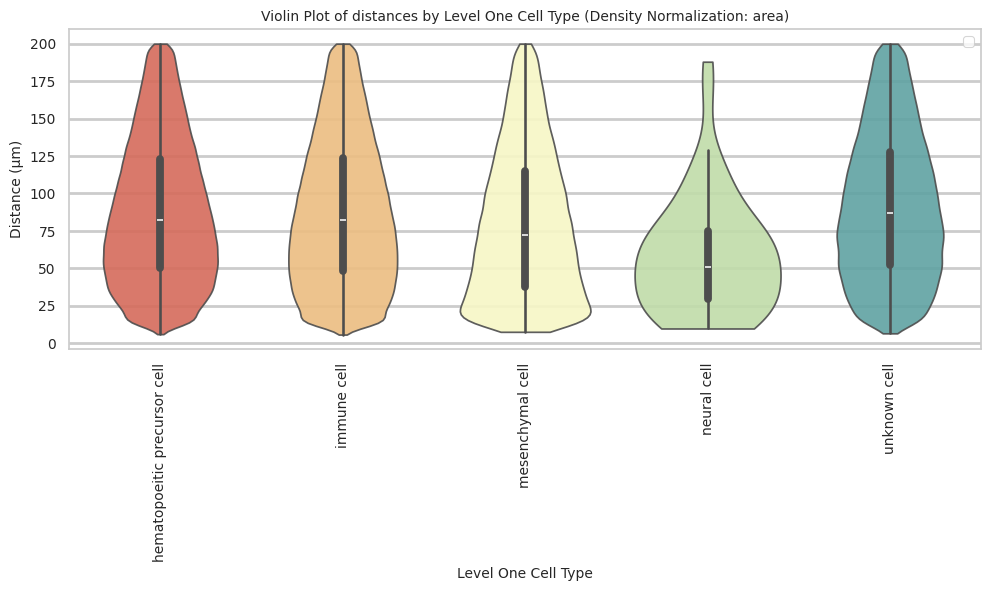

In [30]:
    # Generate Violin Plot
def plot_violin_cells_per_celltype(df_all_edges_with_cell_type_level, cell_type_level, output_dir, density_norm='area'):
    sns.set_style("whitegrid")
    sns.set_context("notebook", rc={"grid.linewidth": 2})
    plt.figure(figsize=(10, 6))

    sns.violinplot(data=df_all_edges_with_cell_type_level, x=cell_type_level, y="Distance", density_norm=density_norm, common_norm=True, cut=0, inner="box", split=False, palette='Spectral', alpha=.9)

    sns.set_theme(style="whitegrid")
    sns.set_context("paper")


    font_size = 10
    plt.legend(fontsize=font_size)

    plt.title(f'Violin Plot of distances by {cell_type_level} (Density Normalization: {density_norm})', fontsize=font_size)

    plt.xlabel(f'{cell_type_level}', fontsize=font_size)
    plt.ylabel('Distance (\u03bcm)', fontsize=font_size)

    # Increase font size for all text in the figure
    plt.xticks(fontsize=font_size)
    plt.xticks(rotation=90)
    plt.yticks(fontsize=font_size)

    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_cells_per_celltype_{cell_type_level}.png'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_cells_per_celltype_{cell_type_level}.svg'), dpi=300,
                bbox_inches='tight',
                pad_inches=0.5)
    plt.show()

plot_violin_cells_per_celltype(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm='area')

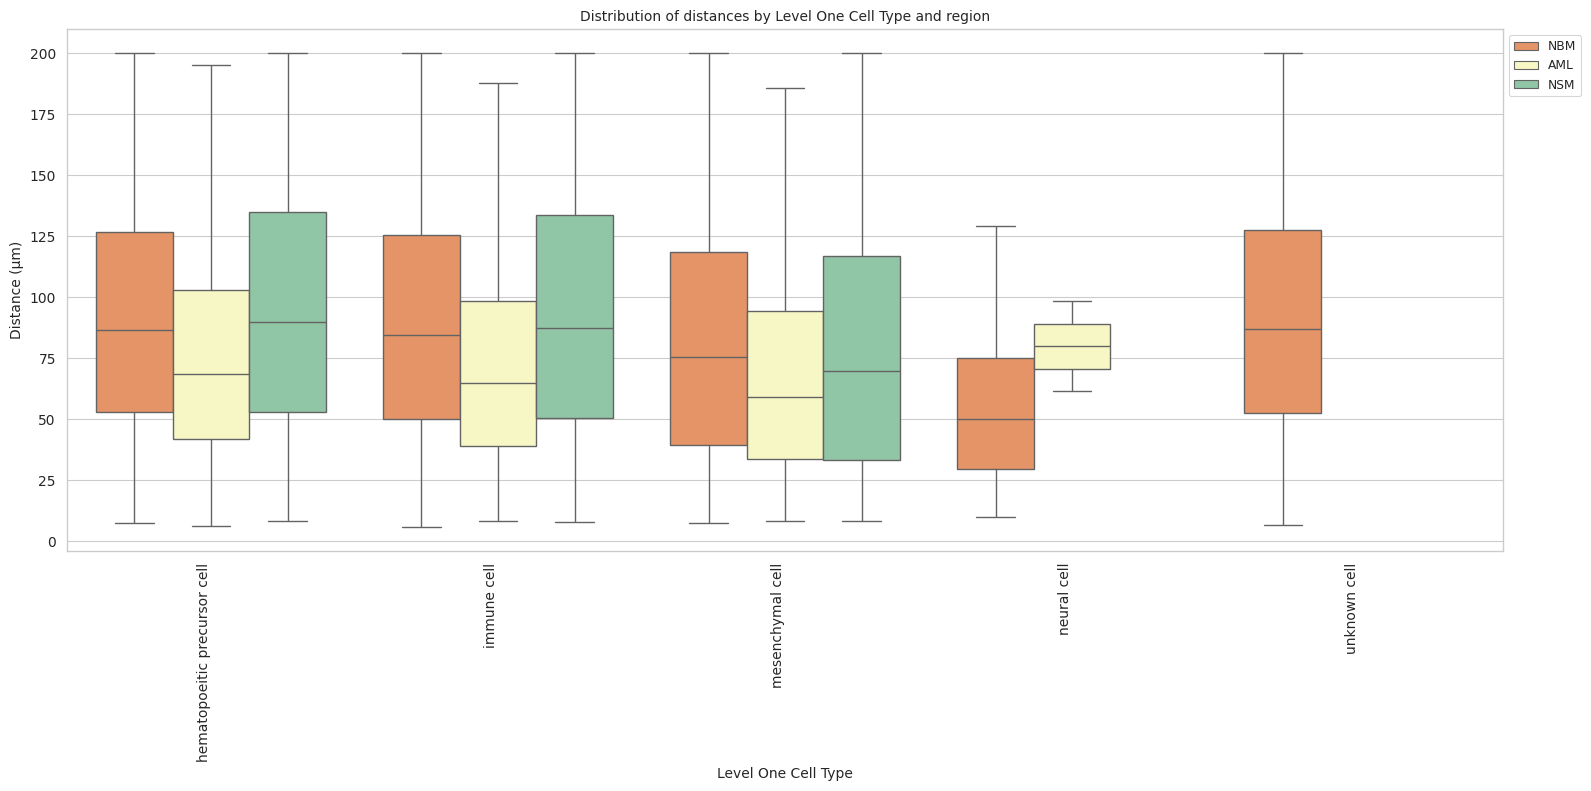

In [31]:
# Boxplots of distribution of distances by cell type and region.
def plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, output_dir):
    plt.figure(figsize=(16, 8))
    # Create categorical type with only the regions that exist in the data
    available_regions = [r for r in regions if r in df_all_edges_with_cell_type_level['Unique Region'].unique()]
    df_all_edges_with_cell_type_level['Unique Region'] = pd.Categorical(
        df_all_edges_with_cell_type_level['Unique Region'],
        categories=available_regions,
        ordered=True
    )

    # Make box plot.
    sns.boxplot(data=df_all_edges_with_cell_type_level, x=cell_type_level, y='Distance', hue='Unique Region', showfliers=False, palette='Spectral') # viridis or Spectral palette for better color distinction
    font_size = 10
    plt.xticks(rotation=90, ha='right', fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.title(f'Distribution of distances by {cell_type_level} and region', fontsize=font_size)
    plt.xlabel(f'{cell_type_level}', fontsize=font_size)
    plt.ylabel('Distance (\u03bcm)', fontsize=font_size)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_boxplots_by_region_{cell_type_level}.png'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_boxplots_by_region_{cell_type_level}.svg'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.show()

plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

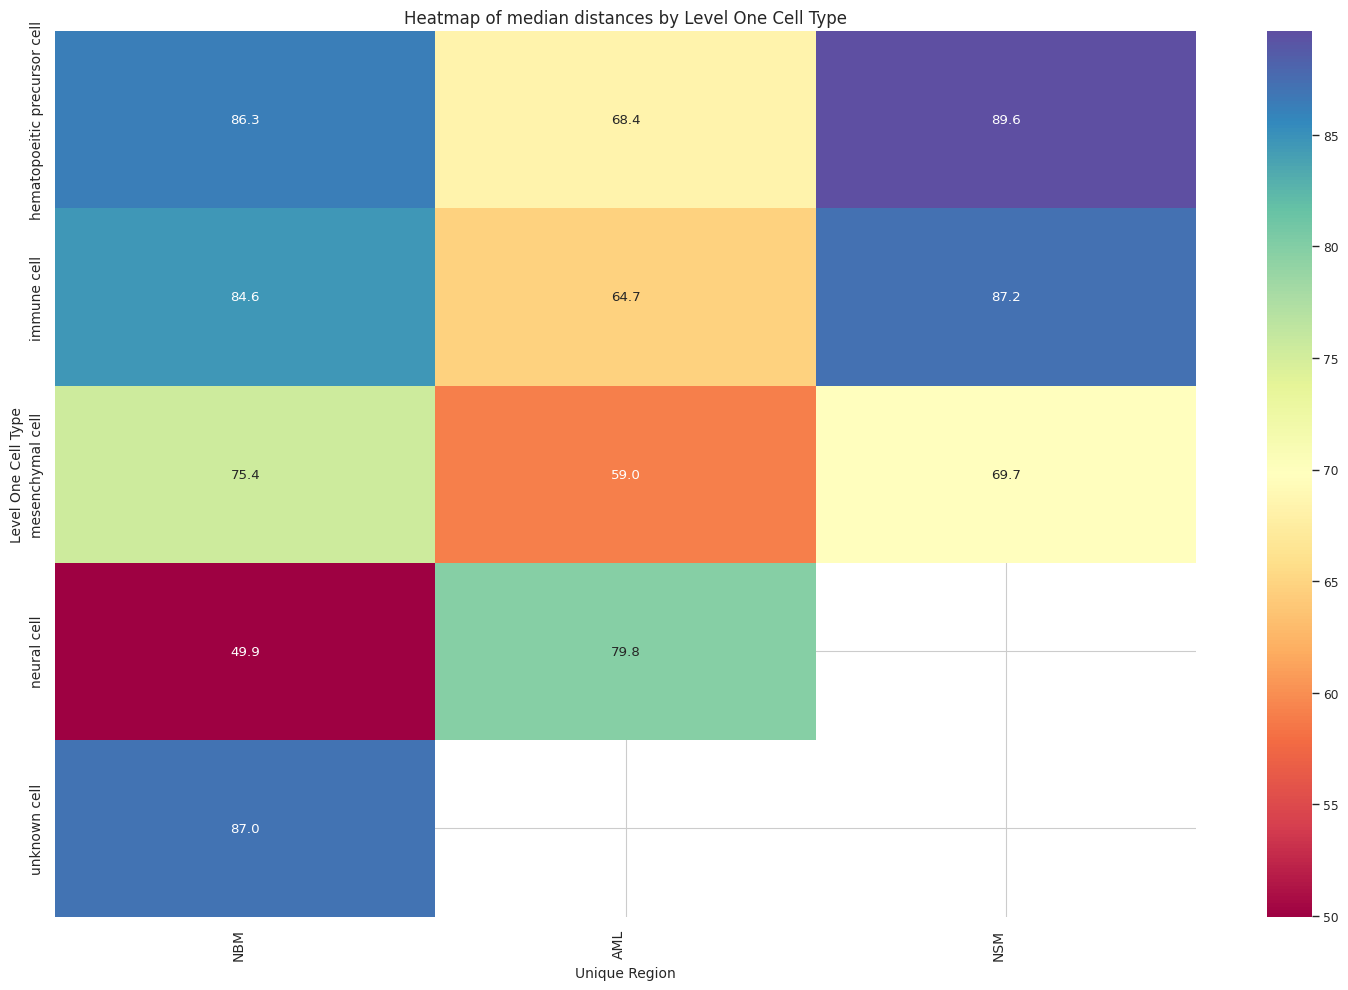

In [32]:
# Boxplots of distribution of distances by cell type and region.
def plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, output_dir):
    pivot_data = df_all_edges_with_cell_type_level.pivot_table(
    values='Distance',
    index=cell_type_level,
    columns='Unique Region',
    aggfunc='median'
    )

    plt.figure(figsize=(15, 10))
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='Spectral')
    plt.title(f'Heatmap of median distances by {cell_type_level}', fontsize=12)

    font_size = 10
    plt.xticks(rotation=90, ha='right', fontsize=font_size)
    plt.yticks(fontsize=font_size)

    plt.xlabel('Unique Region', fontsize=font_size)
    plt.ylabel(f'{cell_type_level}', fontsize=font_size)
    
    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_heatmap_{cell_type_level}.png'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_distance_distribution_heatmap_{cell_type_level}.svg'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.show()

plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

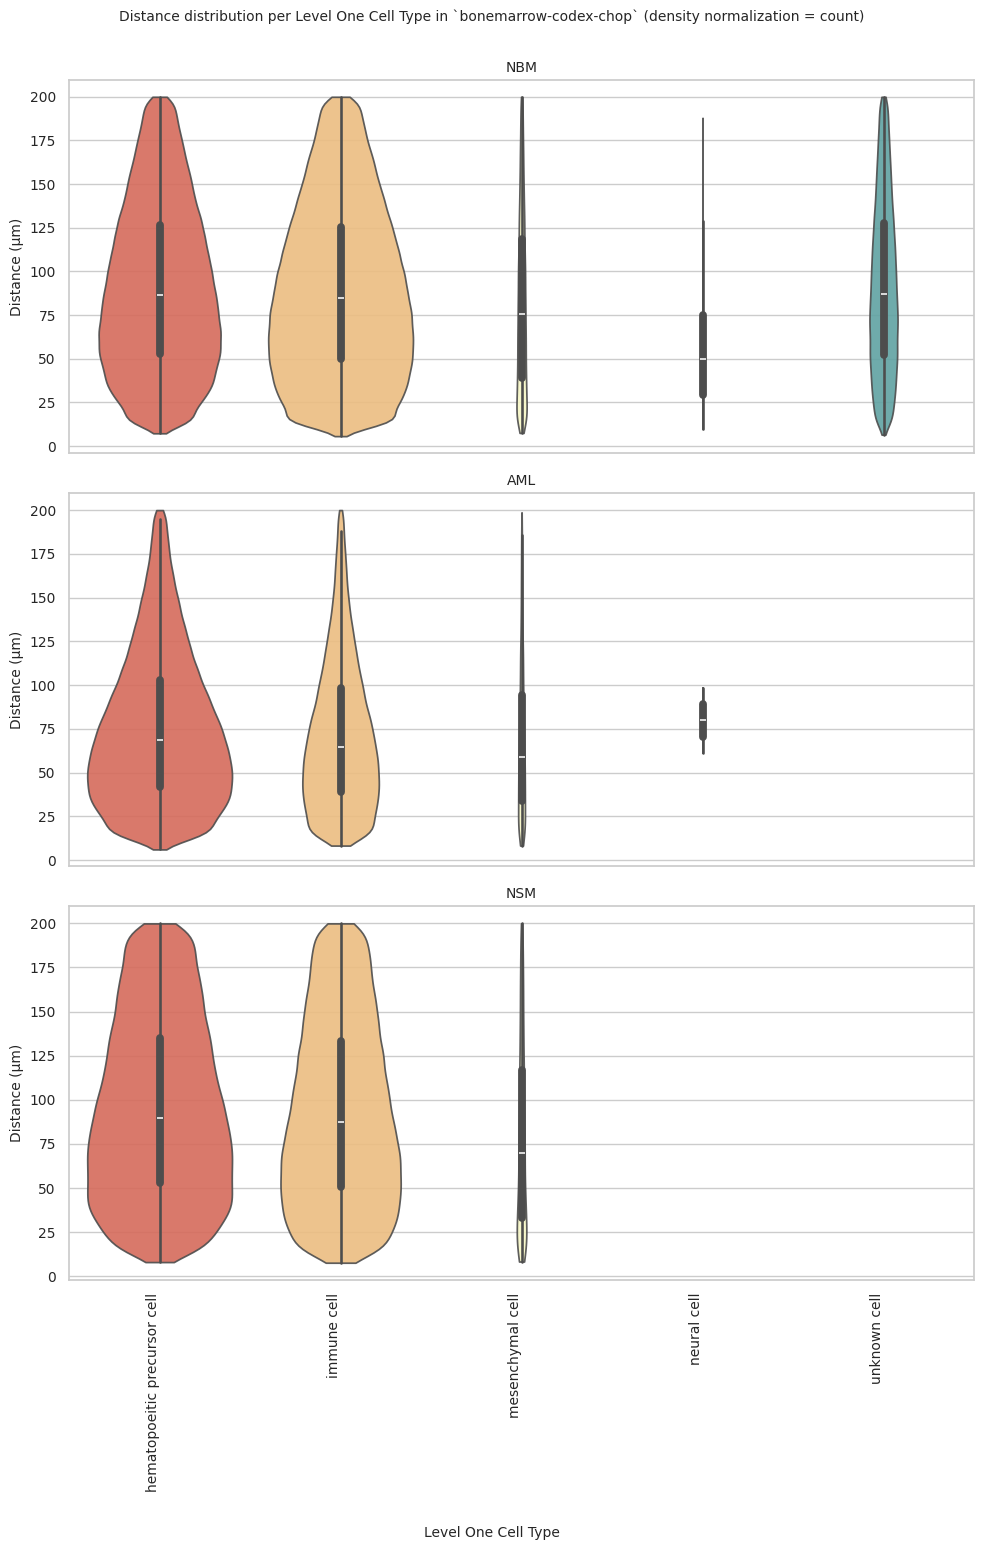

In [33]:
# Generate Violin Plot per unique region in both small intestine and large intestine. Create for all 8 regions as 8 subplots.
def plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, output_dir, density_norm="area"):
    sns.set_style("whitegrid")
    sns.set_context("notebook", rc={"grid.linewidth": 1})
    font_size = 10
    fig, axs = plt.subplots(3, 1, figsize=(10, 15)) # Adjusted figsize for horizontal layout
    fig.suptitle(f'Distance distribution per {cell_type_level} in `{dataset_dir}` (density normalization = {density_norm})', fontsize=font_size, y=1)

    # Keep the sequence of Cell Types consistent across plots.
    cell_types = sorted(df_all_edges_with_cell_type_level[cell_type_level].unique())

    # Create a color palette based on the number of unique classes
    color_palette = sns.color_palette("Spectral", n_colors=len(cell_types))

    # Create a dictionary mapping class to color
    class_color_dict = dict(zip(cell_types, color_palette))

    for i, region in enumerate(regions):
        data_reg = df_all_edges_with_cell_type_level[df_all_edges_with_cell_type_level['Unique Region'] == region]
        sns.violinplot(data=data_reg, x=cell_type_level, y="Distance", density_norm=density_norm, common_norm=True, cut=0, inner="box", split=False, palette=class_color_dict, alpha=.9, ax=axs[i], hue=cell_type_level, legend=False, order=cell_types, fill=True)
        axs[i].set_title(region, fontsize=font_size)
        axs[i].set_xlabel('', fontsize=font_size)
        axs[i].set_ylabel('Distance (\u03bcm)', fontsize=font_size)
        # axs[i].tick_params(axis='x', labelrotation=90, labelsize=font_size)
        # only show xtick labels for the last subplot
        if i < len(regions) - 1:
            axs[i].set_xticklabels([])
        else:
            axs[i].set_xticklabels(cell_types, fontsize=font_size, rotation=90, ha='right')
        # axs[i].set_ylim(0, data_reg['Distance'].max() * 1.1)  # Set y-limits to be consistent across all plots
        axs[i].tick_params(axis='both', labelsize=font_size)

    # Use fig.text for precise label positioning
    fig.figure.text(0.5, -0.02, f'{cell_type_level}', ha='center', va='bottom', fontsize=font_size)

    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_violin_plots_all_regions_{cell_type_level}.png'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    plt.savefig(os.path.join(output_dir, f'{dataset_dir}_violin_plots_all_regions_{cell_type_level}.svg'), dpi=300,
                    bbox_inches='tight',
                    pad_inches=0.5)
    
    plt.show()

plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # density_norm="count" or "area" can be used based on preference.

### Level Two Cell Type Analysis

In [34]:
# Get mean, median, minimum, maximum distance per cell type in all unique regions.
cell_type_level = 'Level Two Cell Type'
df_all_edges_with_cell_type_level = df_all_edges_with_cell_types[(df_all_edges_with_cell_types['Anchor Cell Type Level'] == cell_type_level) & (df_all_edges_with_cell_types['Anchor Cell Type'] == anchor_cell_type_dict[cell_type_level])]

df_distance_stats_cell_type_level = df_all_edges_with_cell_type_level.groupby([cell_type_level, 'Unique Region']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
df_distance_stats_cell_type_level

,Level Two Cell Type,Unique Region,mean_distance,median_distance,min_distance,max_distance
0,abnormal cell,AML,84.612826,78.755366,7.350124,199.982016
1,adipocyte,AML,72.044065,61.569803,9.299294,198.520789
2,adipocyte,NBM,92.656243,88.435461,8.040248,199.992343
3,adipocyte,NSM,84.007363,76.639037,8.344688,199.997910
4,b cell,AML,78.392682,71.243188,9.244128,199.966621
5,b cell,NBM,97.615652,95.012793,8.025751,199.996640
6,b cell,NSM,96.232882,91.578635,9.240345,199.991504
7,dendritic cell,AML,79.071847,72.219946,9.452268,199.541677
8,dendritic cell,NBM,94.921339,90.375897,8.032959,199.978479
9,dendritic cell,NSM,96.121120,90.482325,10.456776,199.356229


In [35]:
# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_mean(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in NSM:
                       Level Two Cell Type  mean_distance
5   hematopoietic stem and progenitor cell     104.959083
7                            megakaryocyte      98.796581
4                     erythroid precursor       97.332711
14                         progenitor cell      97.117247
13                       myeloid precursor      97.037575

Bottom 5 cell types in NSM:
           Level Two Cell Type  mean_distance
15       skeletal stromal cell      89.169229
8        mesenchymal stem cell      87.206186
0                    adipocyte      84.007363
3   endothelial cell of artery      65.333875
11                 muscle cell      55.313443

Top 5 cell types in AML:
   Level Two Cell Type  mean_distance
15     neuroglial cell     128.321993
0        abnormal cell      84.612826
11            monocyte      82.273906
14   myeloid precursor      80.963771
19              t cell      80.957774

Bottom 5 cell types in AML:
                       Level Two Cell 

In [36]:
# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_median(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])



Top 5 cell types in NSM:
                       Level Two Cell Type  median_distance
5   hematopoietic stem and progenitor cell        98.965058
7                            megakaryocyte        92.705512
14                         progenitor cell        92.464861
4                     erythroid precursor         92.296305
13                       myeloid precursor        92.060765

Bottom 5 cell types in NSM:
              Level Two Cell Type  median_distance
9   mesenchymal stem/stromal cell        80.083330
15          skeletal stromal cell        77.967966
0                       adipocyte        76.639037
3      endothelial cell of artery        55.348929
11                    muscle cell        46.465657

Top 5 cell types in AML:
   Level Two Cell Type  median_distance
15     neuroglial cell       128.321993
0        abnormal cell        78.755366
11            monocyte        76.137286
19              t cell        73.440678
14   myeloid precursor        73.387438

Bottom 5 cel

In [37]:
calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level)


Regional Variability Analysis:
Mean: Average distance in each region
Std: Standard deviation of distances
CV: Coefficient of Variation (std/mean * 100%)
                mean    std  CV (%)
Unique Region                      
AML            79.39  44.80    56.4
NBM            95.30  48.83    51.2
NSM            95.64  51.03    53.4

Cell Type Variability Analysis (sorted by CV):
                                         mean    std  CV (%)
Level Two Cell Type                                         
endothelial cell of artery              77.69  52.16    67.1
muscle cell                             87.24  50.87    58.3
skeletal stromal cell                   92.68  52.72    56.9
adipocyte                               89.36  50.19    56.2
monocyte                                89.60  49.68    55.4
mesenchymal stem cell                   87.59  48.55    55.4
mesenchymal stem/stromal cell           89.52  48.91    54.6
dendritic cell                          89.61  48.91    54.6
t cell  

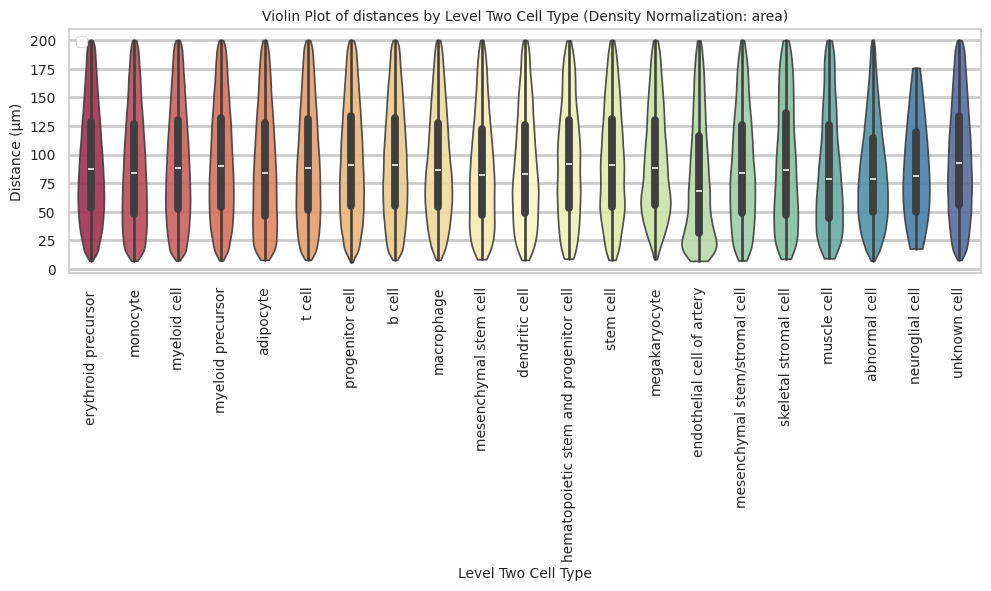

In [38]:
plot_violin_cells_per_celltype(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm='area')

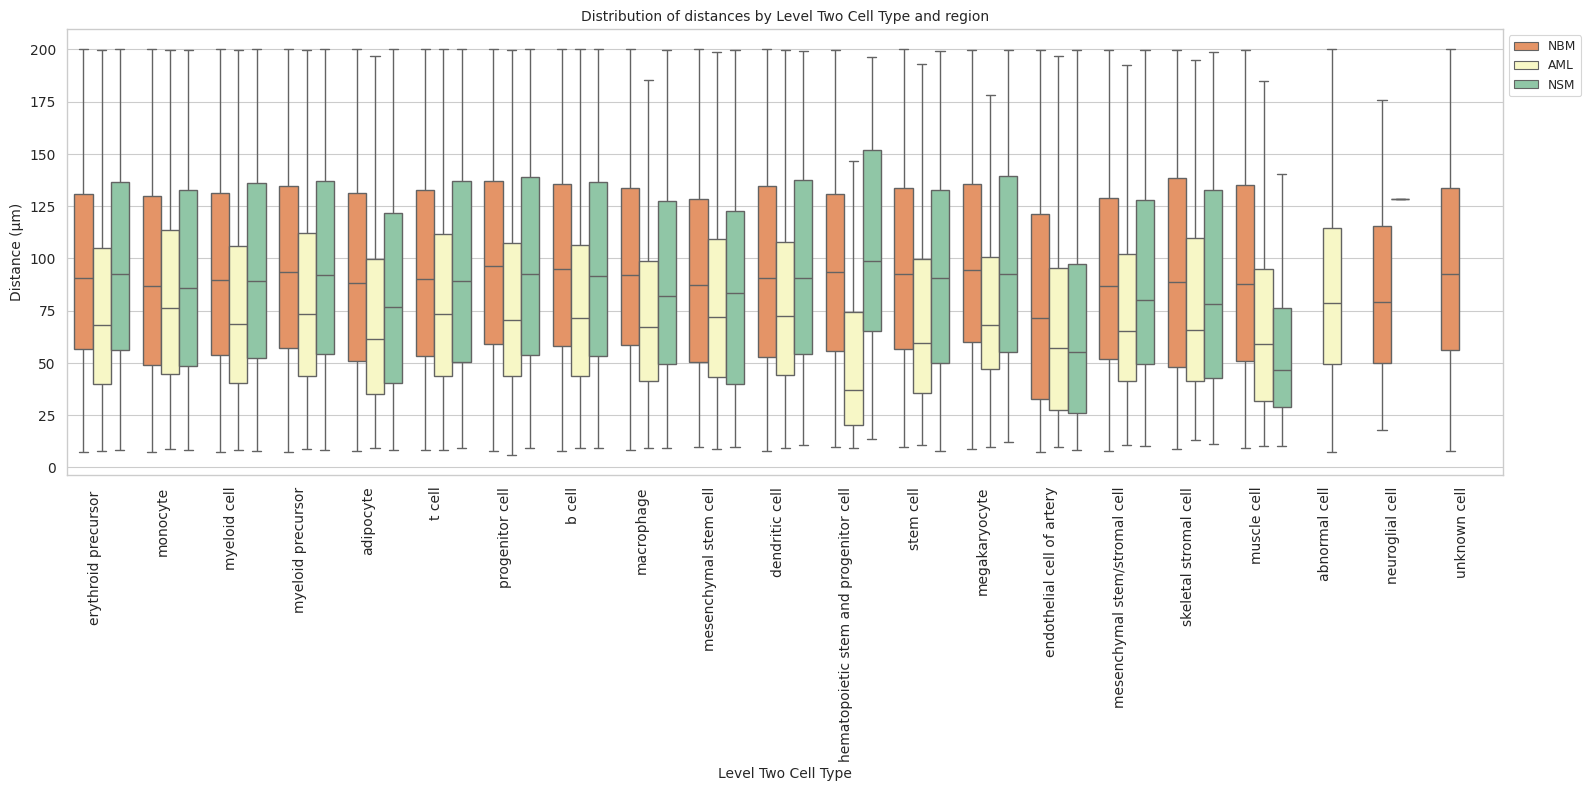

In [39]:
plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

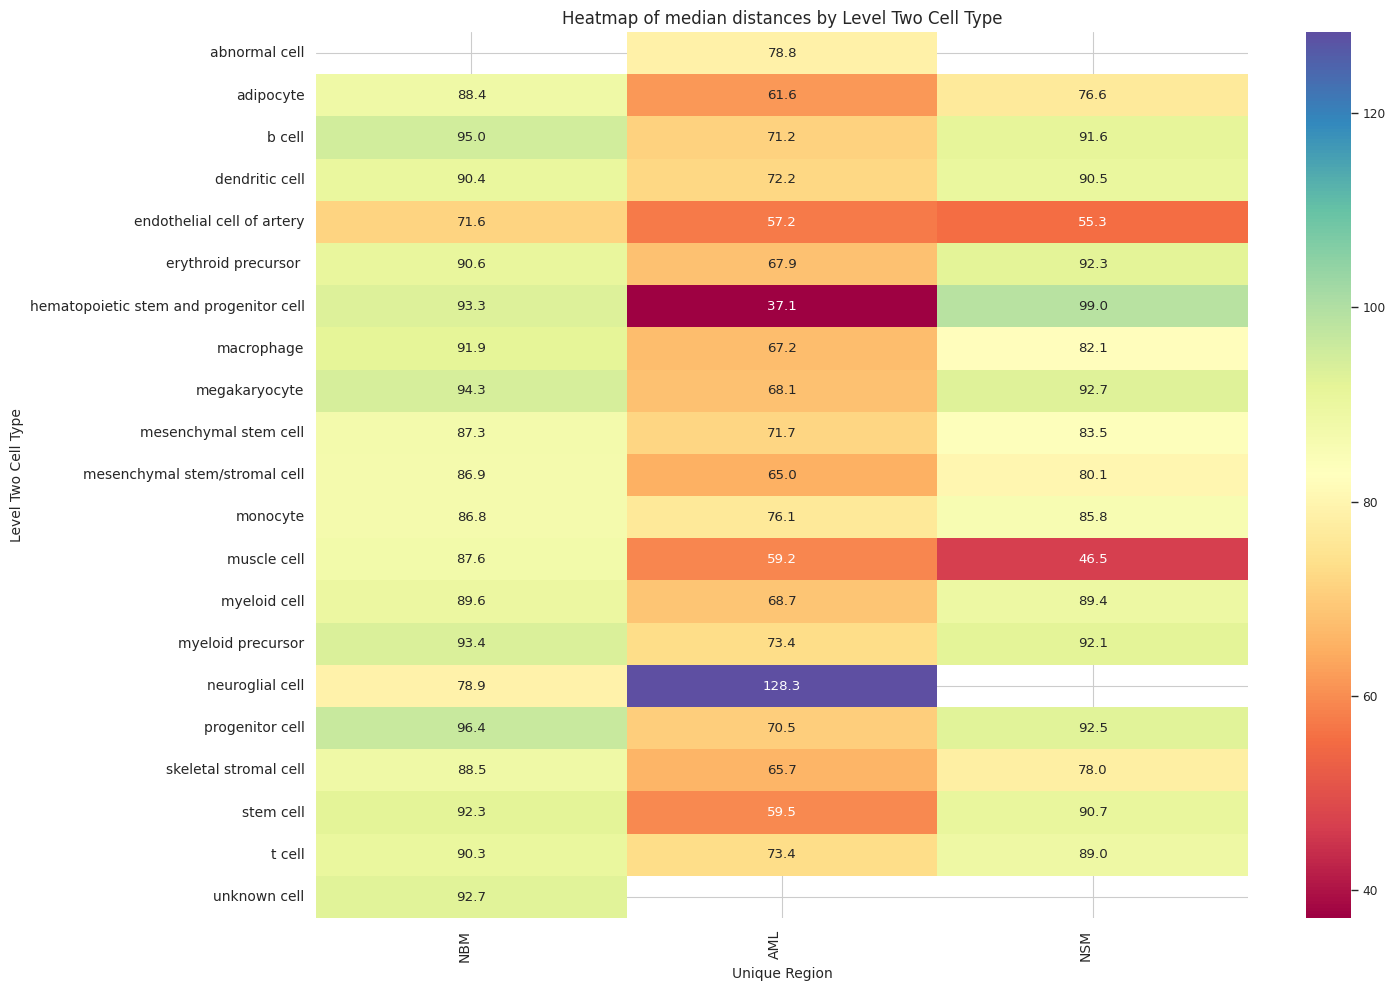

In [40]:
plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

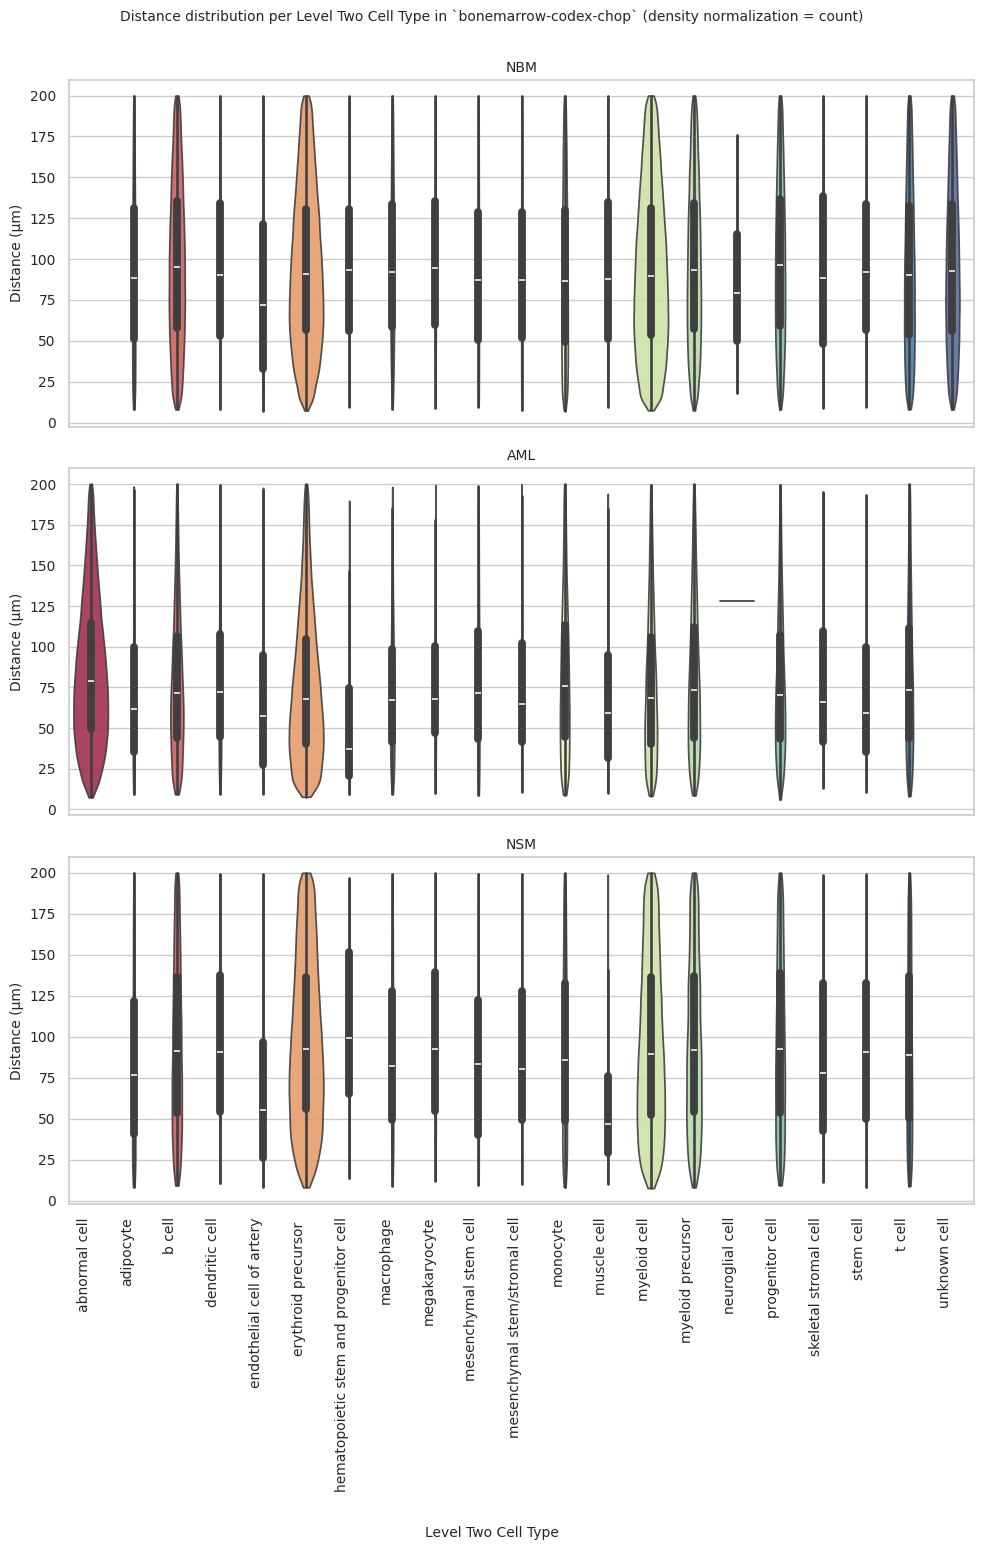

In [41]:
plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # Or, density_norm="count" or "area" based on preference.

### Level Three Cell Type Analysis

In [42]:
# Get mean, median, minimum, maximum distance per cell type in all unique regions.
cell_type_level = 'Level Three Cell Type'
df_all_edges_with_cell_type_level = df_all_edges_with_cell_types[(df_all_edges_with_cell_types['Anchor Cell Type Level'] == cell_type_level) & (df_all_edges_with_cell_types['Anchor Cell Type'] == anchor_cell_type_dict[cell_type_level])]

df_distance_stats_cell_type_level = df_all_edges_with_cell_type_level.groupby([cell_type_level, 'Unique Region']).agg(
    mean_distance=('Distance', 'mean'),
    median_distance=('Distance', 'median'),
    min_distance=('Distance', 'min'),
    max_distance=('Distance', 'max')
).reset_index()
df_distance_stats_cell_type_level

,Level Three Cell Type,Unique Region,mean_distance,median_distance,min_distance,max_distance
0,adipocyte,AML,72.044065,61.569803,9.299294,198.520789
1,adipocyte,NBM,92.656243,88.435461,8.040248,199.992343
2,adipocyte,NSM,84.007363,76.639037,8.344688,199.997910
3,b cell,AML,76.143453,68.752778,9.244128,199.966621
4,b cell,NBM,96.138631,92.508923,8.025751,199.972480
5,b cell,NSM,94.707460,89.148689,9.240345,199.991504
6,b cell:immature,AML,82.461384,75.703532,10.072227,199.483659
7,b cell:immature,NBM,99.501175,96.731118,8.874948,199.954603
8,b cell:immature,NSM,97.478212,92.747527,9.555029,199.569086
9,cell:cd34+ cd61+,AML,74.287460,57.285741,11.620897,170.297284


In [43]:
# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_mean(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in NSM:
                             Level Three Cell Type  mean_distance
10            granulocyte monocyte progenitor cell     113.471237
12  hematopoietic stem and progenitor cell:spink2+     104.959083
7                                     erythroblast      99.975515
16                            megakaryocyte:gata1+      99.813171
2                                  b cell:immature      97.478212

Bottom 5 cell types in NSM:
              Level Three Cell Type  mean_distance
8           erythroblast:basophilic      69.175800
6        endothelial cell of artery      65.333875
22               muscle cell:smooth      55.313443
3                  cell:cd34+ cd61+      54.635086
14  lymphoid progenitor cell:common      48.644547

Top 5 cell types in AML:
     Level Three Cell Type  mean_distance
28            schwann cell     128.321993
23       mutant blast:npm1      84.612826
21  monocyte:non-classical      84.404224
2          b cell:immature      82.461384
29  t c

In [44]:
# Get top and bottom cell types for each unique region in the dataset.
unique_regions = df_all_edges_with_cell_type_level['Unique Region'].unique()
for region in unique_regions:
    top_bottom = get_top_bottom_cell_types_by_median(df_all_edges_with_cell_type_level, cell_type_level, region)
    print(f"\nTop 5 cell types in {region}:")
    print(top_bottom[0])
    print(f"\nBottom 5 cell types in {region}:")
    print(top_bottom[1])


Top 5 cell types in NSM:
                             Level Three Cell Type  median_distance
10            granulocyte monocyte progenitor cell       118.935939
12  hematopoietic stem and progenitor cell:spink2+        98.965058
7                                     erythroblast        94.923044
16                            megakaryocyte:gata1+        94.046165
26                                     plasma cell        93.114820

Bottom 5 cell types in NSM:
              Level Three Cell Type  median_distance
6        endothelial cell of artery        55.348929
3                  cell:cd34+ cd61+        52.248486
8           erythroblast:basophilic        50.068324
14  lymphoid progenitor cell:common        48.644547
22               muscle cell:smooth        46.465657

Top 5 cell types in AML:
     Level Three Cell Type  median_distance
28            schwann cell       128.321993
23       mutant blast:npm1        78.755366
21  monocyte:non-classical        77.154945
20               

In [45]:
calculate_regional_variability(df_all_edges_with_cell_type_level, cell_type_level)


Regional Variability Analysis:
Mean: Average distance in each region
Std: Standard deviation of distances
CV: Coefficient of Variation (std/mean * 100%)
                mean    std  CV (%)
Unique Region                      
AML            79.39  44.80    56.4
NBM            95.30  48.83    51.2
NSM            95.64  51.03    53.4

Cell Type Variability Analysis (sorted by CV):
                                                  mean    std  CV (%)
Level Three Cell Type                                                
endothelial cell of artery                       77.69  52.16    67.1
muscle cell:smooth                               87.24  50.87    58.3
endosteal cell                                   92.68  52.72    56.9
monocyte:non-classical                           88.77  50.37    56.7
adipocyte                                        89.36  50.19    56.2
mesenchymal stem cell of adipose tissue          87.59  48.55    55.4
monocyte                                         89.70  49

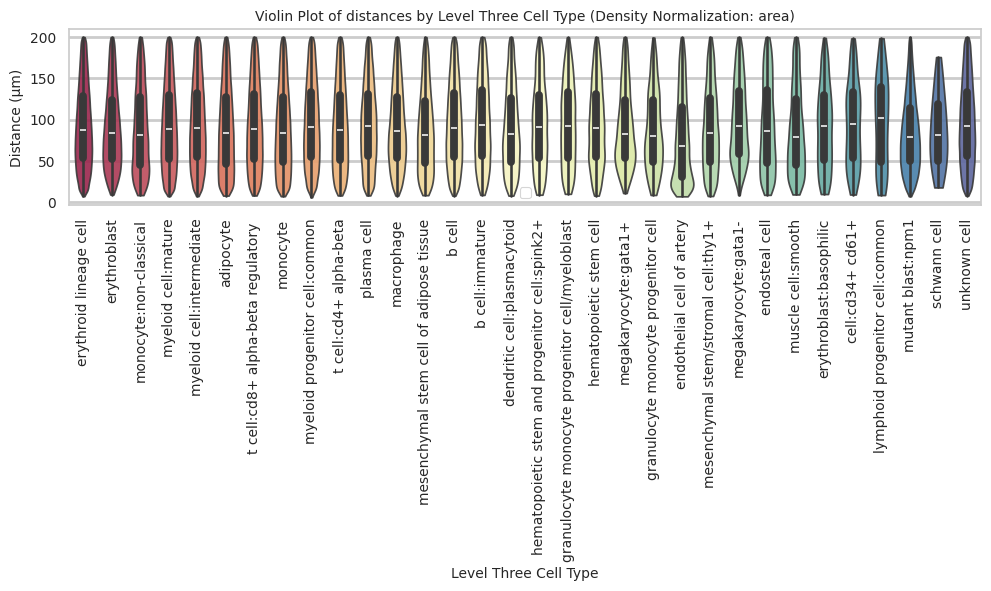

In [46]:
plot_violin_cells_per_celltype(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm='area')

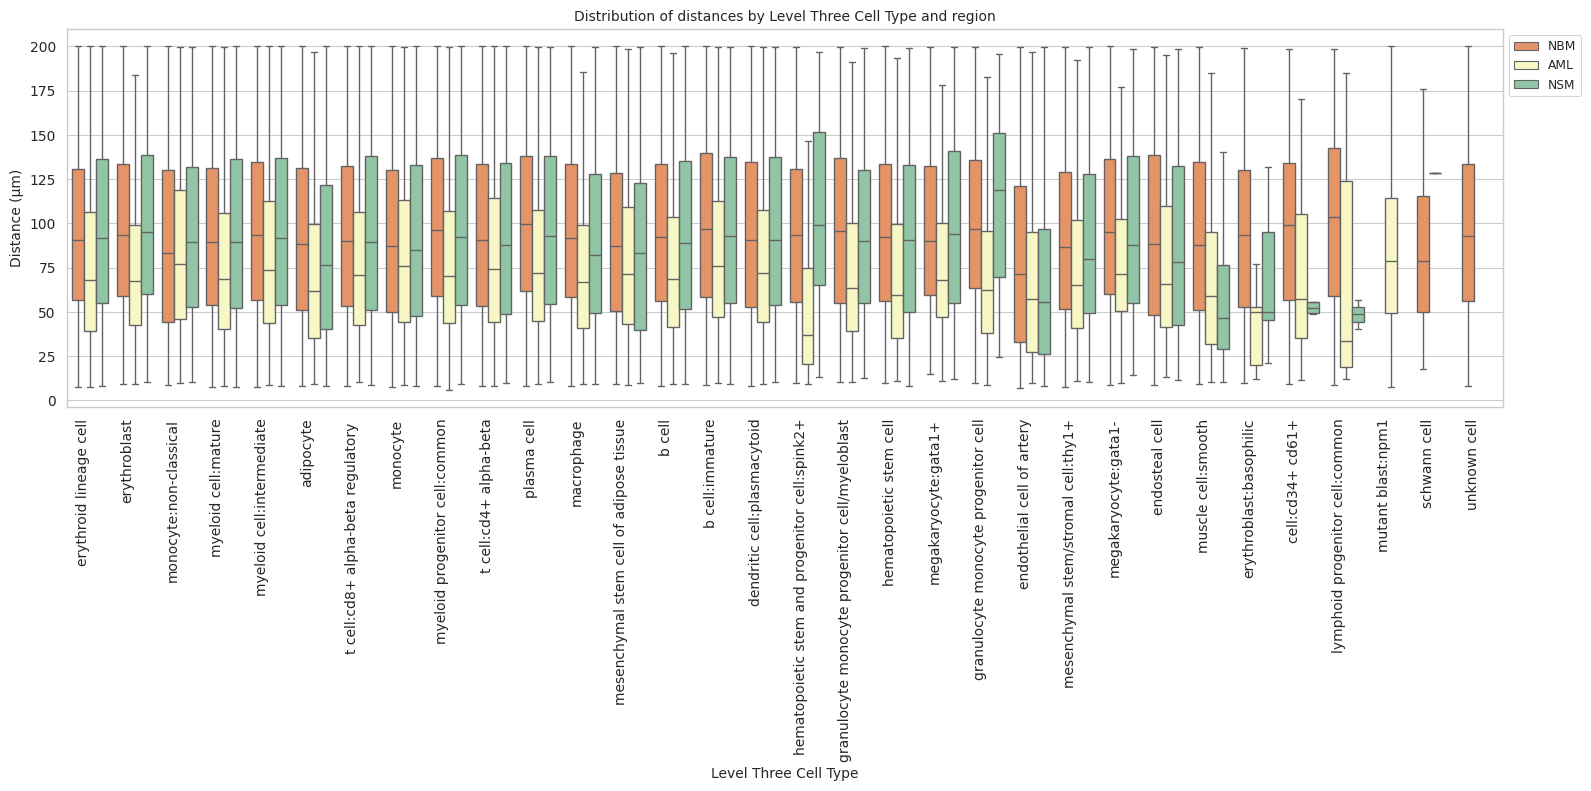

In [47]:
plot_distance_distribution_boxplots_by_region(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

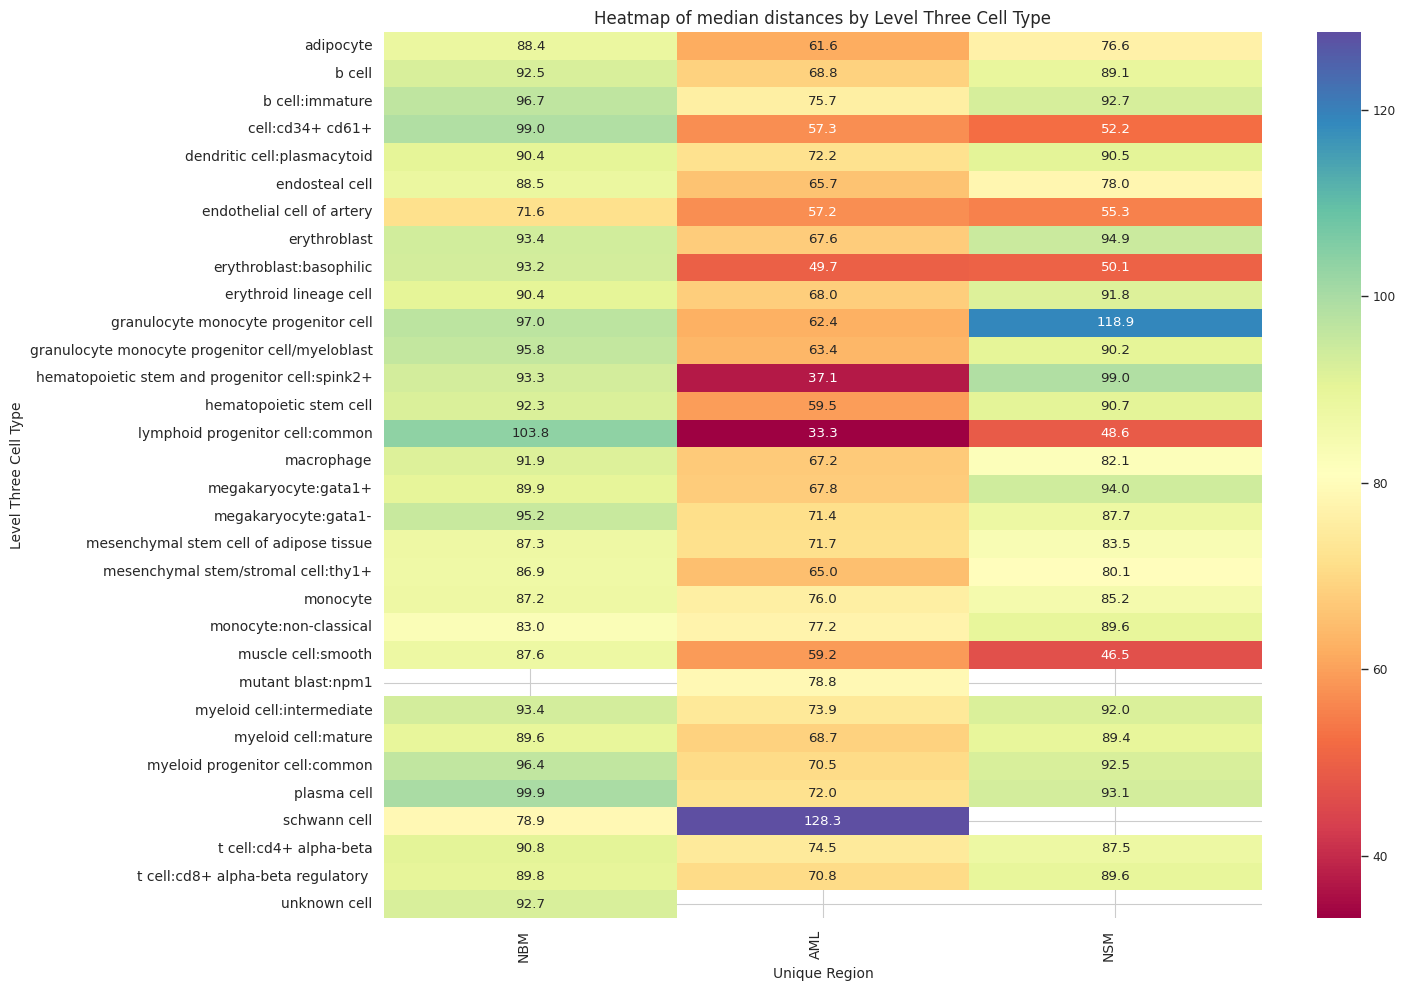

In [48]:
plot_distance_distribution_heatmap(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir))

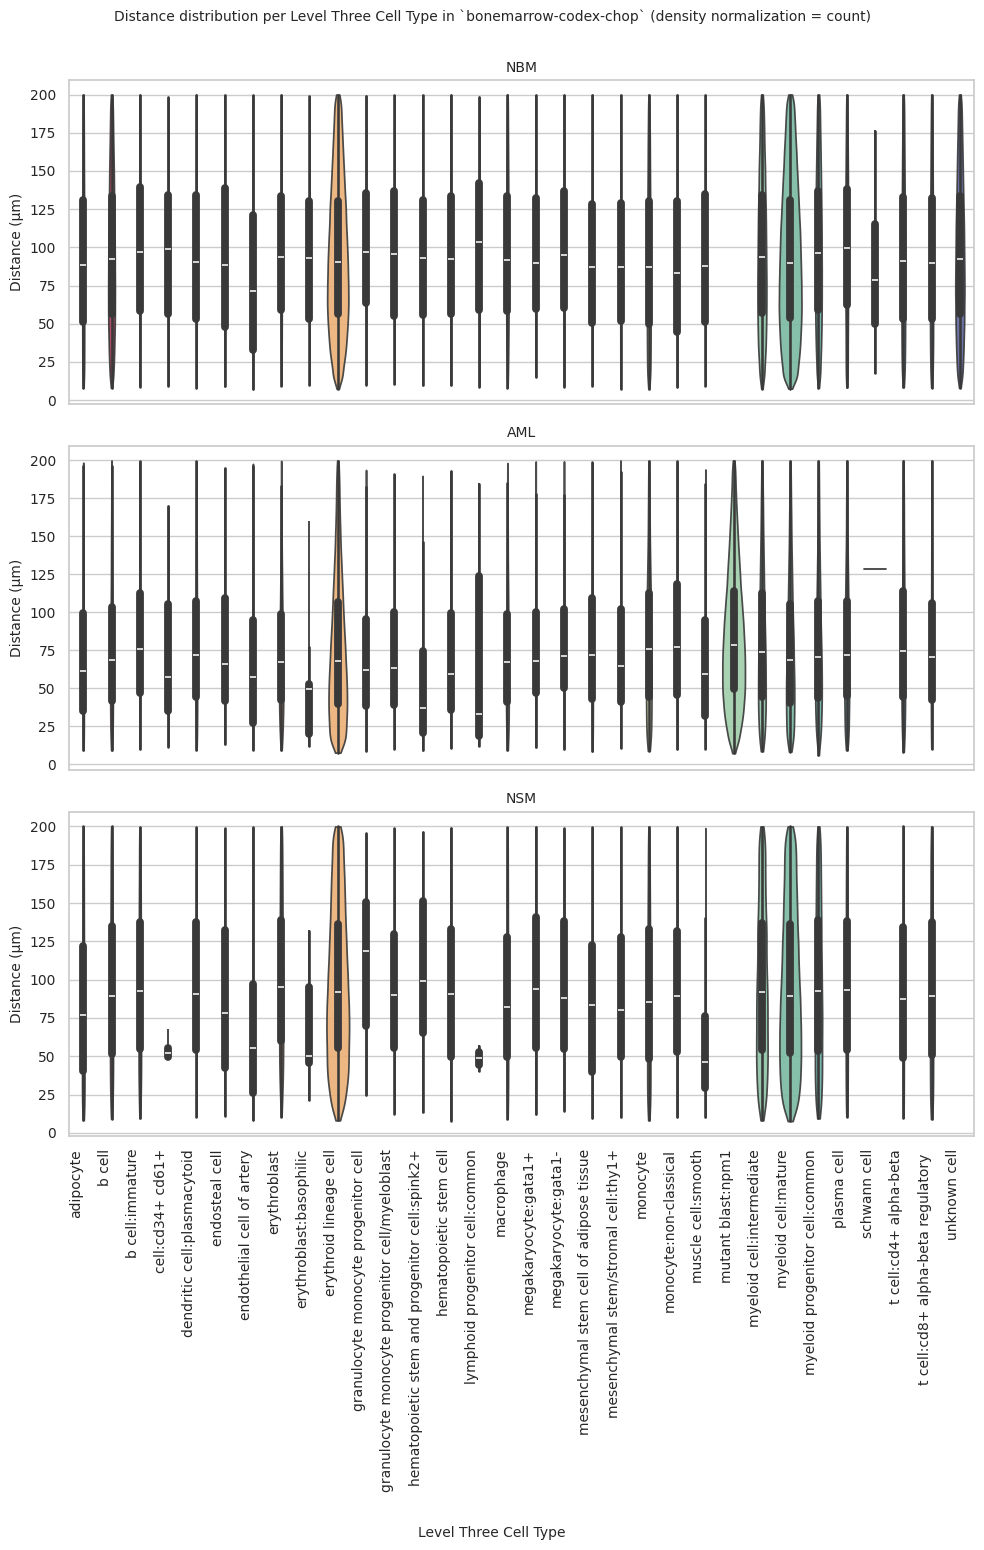

In [49]:
plot_violin_plots_all_regions(df_all_edges_with_cell_type_level, cell_type_level, os.path.join(basepath, figures_output_dir), density_norm="count") # Or, density_norm="count" or "area" based on preference.